In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Data science in practice

Being a successful Data Scientist is much more than just knowing models.

Being able to gather, join, and clean Data is a prerequisite to being able to train a model.
- the remarkable success of Large Langauge Models (e.g., ChatGPT) is in large part due to vast quantities of carefully curated data

*Manipulating and transforming* the Data into a form in which a successful model can be built
is a skill that may not be truly appreciated.
- data is frequently transformed from its raw form to synthesized features and targets
- the relationship between features and target may not be present in raw form

It is this latter skill that we know focus on.

Recall the Fundamental Assumption of Machine Learning

- That each training and test example $(\x, \y)$ 
- is a sample drawn from $\pdata$
- where $\pdata$ is the true (but unknown) distribution of examples


It is surprisingly easy to violate this assumption

Consider the timeseries of prices of an equity

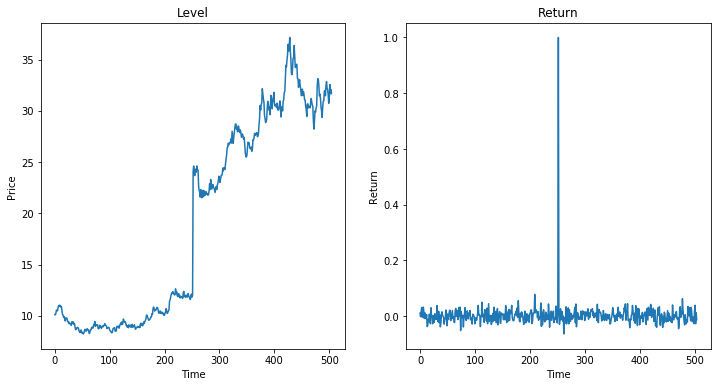

In [7]:
fig_data

One can easily see that there are two distributions here
- a low-mean (and low variance) distribution prior to the jump in Price
- a high-mean (and high variance) distribution after the jump

The test data (drawn post jump) is **not** from the same distribution as the training data (pre-jump).

In fact: if the training data also includes examples post-jump
- it would seem that the training data comes from the union of *two different* distributions

At first glance, this seems surprising.

After all, each Price is drawn from the distribution of a single equity.

But, as is very typical in Finance, our distributions *vary with time*.

So, in order to satisfy the Assumption
- we typically transform the Price distribution into a Return distribution
- which is often (but not always) more stable over time

This also has the benefit of making sure that the training examples all come from a single distribution.
- The more homogeneous the distribution
- The more statistical support there is for the model

# Non-homogeneous data

We will imagine that the available data comes from one or more *groups* each with its own distribution.

One typical reason for more than one group is time-varying data.

Consider the following graph illustrating the joint distribution of Price (target) and Size (features)


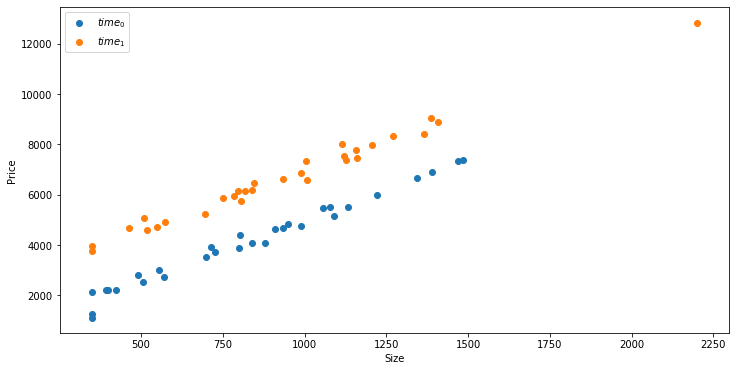

In [8]:
fig_sp

Another cause for more than one group is differences in market/geography.

Consider the plot

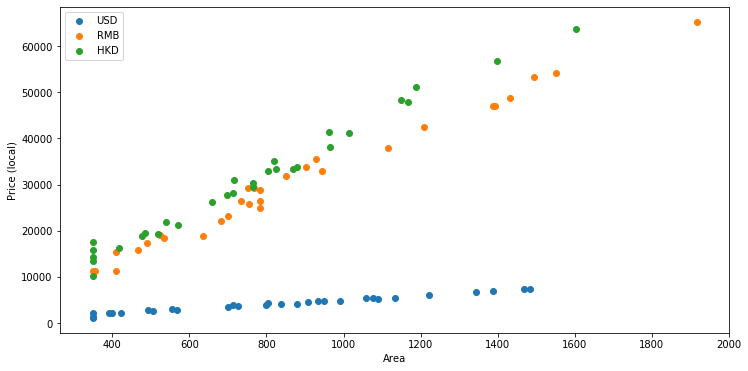

In [9]:
fig_rp

Even though each group seems different **on the surface**
- there may be a *single* relationship between targets and features
- that is the *same* across groups
- at a **deeper** level

Being able to transform data to uncover the deeper level relationship between targets and features
- is a skill **critical to being able to construct good models**

By the way: 
- it may take some detective work to even discover that there is more than one group !
- examples are not always labeled as being from distinct groups
    - i.e., you don't have the advantage of different colors for different groups in the graph

## Why do we have to deal with non-homogeneous data ?

- The examples may be presented as a mixture
- You often need to **pool** groups in order to enlarge the number of examples for training
    - more examples facilitate better models
    - and more parameters
    

For example, a lot of Financial data is sampled at low frequency (e.g., daily)
- So not a lot of data points for a single ticker in a short time period
- Pool over time to increase number of examples
    - groups caused by time-varying distribution of single stock price/return
- Pool over many similar tickers to increase number of examples
    - distribution per ticker is different

Consider the following example.

Suppose our goal is to predict whether a borrow will prepay a mortgage.  

As raw features: we have variables
- Borrower's interest rate $C$
- Rate $r$ at a which a mortgage could be re-financed

The borrower has an incentive to prepay if $C > r$.

What training examples should we use ?

Remember: we want the test examples (observed in the near future) to be similar to the training examples.

Should our examples only include instances where $r \approx r'$
- where $r'$ is today's re-finance rate

We may not have a lot of *historical* data with a contemporaneous re-finance rate close to $r'$.

Consider a different approach to modeling:
- we use a *synthetic* feature $I$  capturing incentive to prepay
- rather than just raw values $C, r$ for borrower's current rate and contemporaneous re-finance rate

For example, we could create feature $I$ in several possible ways
- $I = \max{}(0, C-r)$
- $I = \max{}(0, \frac{C}{r} -1)$



Using the synthetic feature opens up the possibility of using a lot more historical data
- Many more historical episodes with a particular value of $\frac{C}{r}$ or $C-r$
- Than examples where the then-current re-finance rate equals today's rate $r$

In essence
- we have pooled data over time
- each time period defines a different group (similar values of $r$)
- different groups have different distributions
- that we *have made uniform* by using $I$ rather than $C$ and $r$ as features

**A key skill of a Data Scientist** is the ability
- to strip away surface differences and reveal underlying commonality between groups
- being able to adapt models to deal with multiple groups

# Non-homogeneous data: make it (more) Homogeneous

## Normalization via z-score

Let's consider a simple dataset with examples that are drawn from two different groups

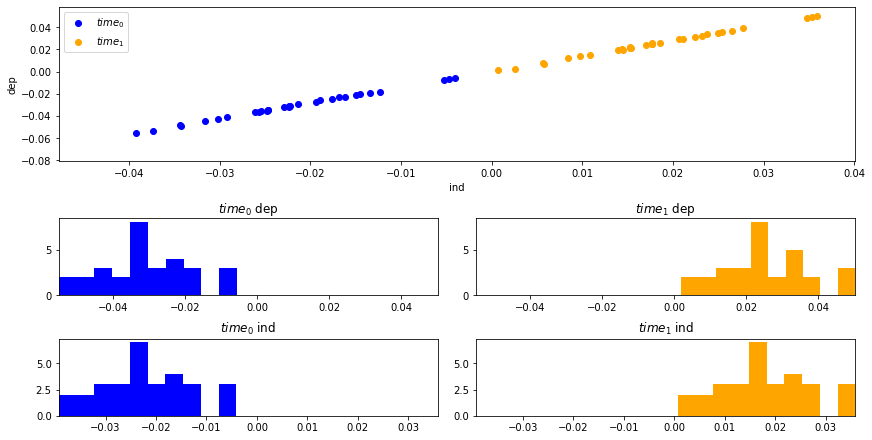

In [10]:
sph = transform_helper.StockReturn_Pooling_Helper()

means = [ -.02, +.02 ]
s = .16/(252**.5)

df_2means = sph.gen_returns(means, [s, s])

_= sph.plot_data(df_2means)

From the top graph: we can see that there is a constant linear relationship
- between target "dep" and feature "ind"
- both within groups and across groups

From the second and third rows, we see the distribution of features and targets
- has same shape between groups
- with different means

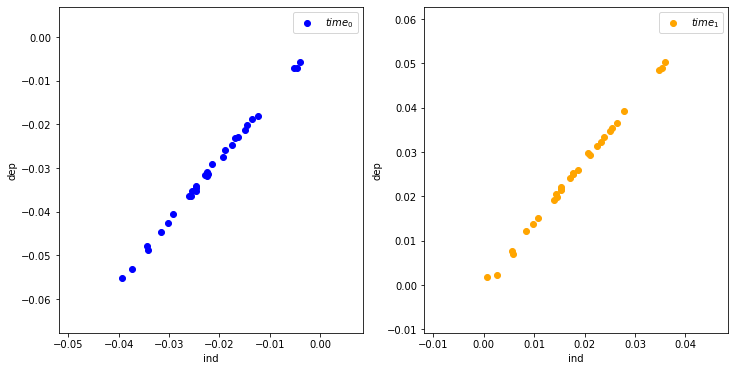

In [11]:
_= sph.plot_segments(df_2means)

Given the simple linear relationship intra-group
- No harm would come from pooling
- Even though the pooled data comes from distinct groups

*However*: it the intra-group relationship was more complex (e.g., a curve)
- pooling would be less successful

So although this example may be over-simplified, we still try to make the distinct groups look similar.

Let's normalize each group
- for each variable: turn values into z-scores
    - subtract variable mean, divide by variable standard deviation

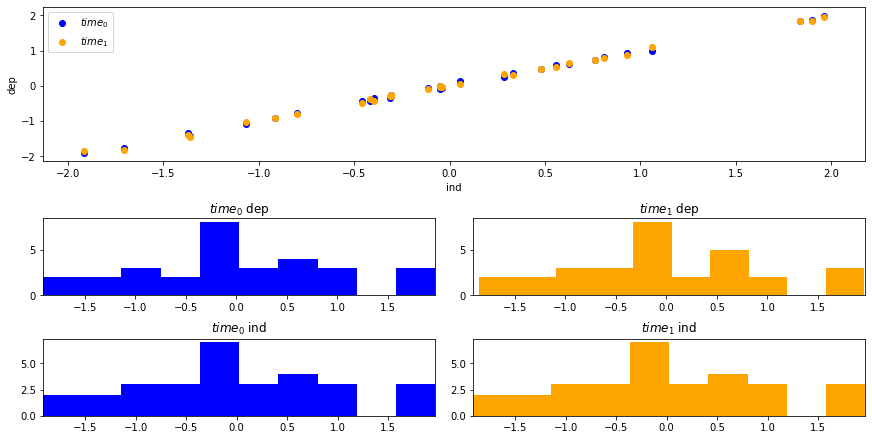

In [12]:
df_2means_norm = sph.normalize_data(df_2means)
_= sph.plot_data(df_2means_norm)

You can now see that the two groups are
- congruent in the top joint plot
- have same distributions in the second and third rows

Non-homogeneous groups made homogeneous !

We can make the separation between groups less trivial by also having different standard deviations per group.

Here's what the data looks like

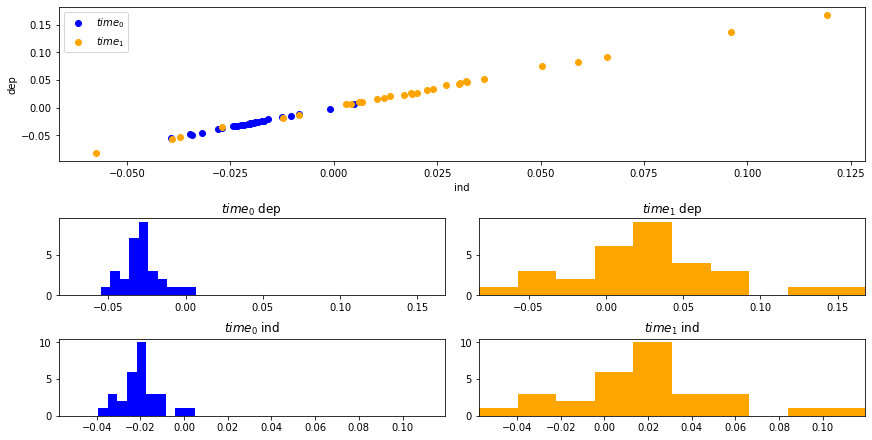

In [13]:
df_2means_2sdevs = sph.gen_returns(means, [s, 4*s])

_= sph.plot_data(df_2means_2sdevs)

Again: normalization does the trick

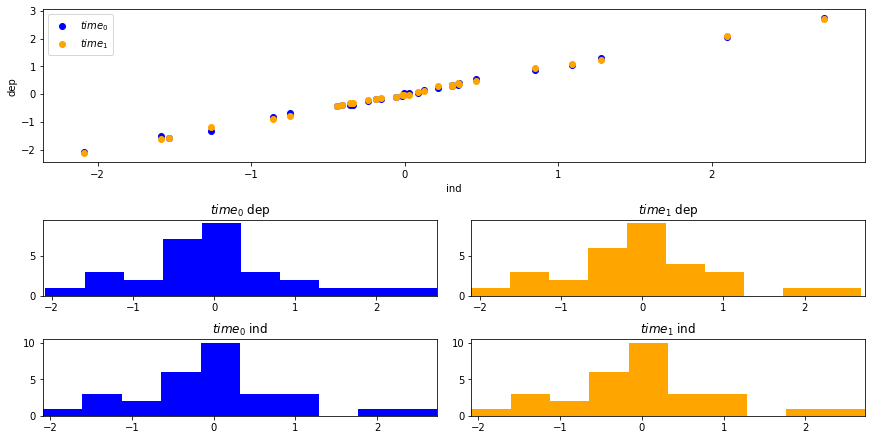

In [14]:
df_2means_2sdevs_norm = sph.normalize_data(df_2means_2sdevs)
_= sph.plot_data(df_2means_2sdevs_norm)

## Normalization by uncovering the hidden relationship

Consider the following multi-group data
- house price as a function of size
- in different geographies

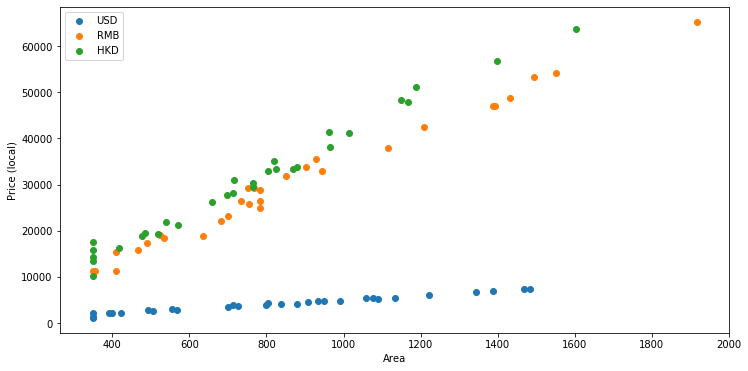

In [15]:
fig_rp

There is clearly a linear relationship intra-group, but the slope differs between groups (local currencies).

The apparent diversity in the target may obscure a simple relationship that is common to all groups

Let's re-denominate the target in a common unit.
- Let the target of example $i$ in group $g$ be
$$\y^\ip_{(\text{group}_g)}$$
- Change the units in which $\y^\ip_{(\text{group}_g)}$ is expressed
- Into a common unit
- Via an "exchange rate" equal to the slope of group $g$
$$
\beta_{(\text{group}_g)}
$$
- yielding
$$\tilde{\y}^\ip_{(\text{group}_g)} = \frac{\y^\ip_{(\text{group}_g)}}{ \beta_{(\text{group}_1)}}$$

If we do this for each group (separately) the data becomes homogeneous !

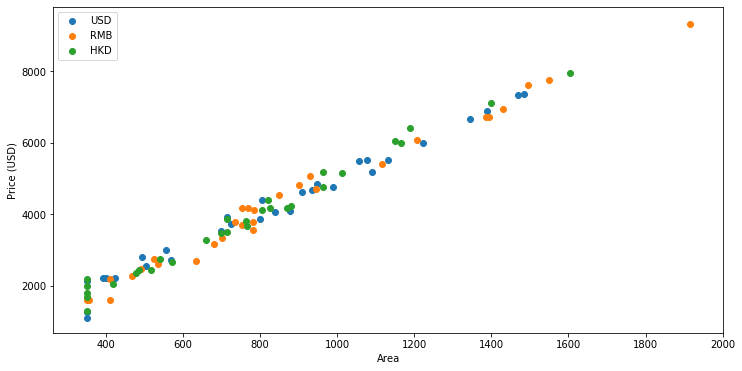

In [16]:
# Relative price levels
rel_price = rph.relative_price()

# Normalize the price of each series by the relative price        
series_normalized = [ series[i]/(1,rel_price[i]) for i in range(len(series))]

fig_rp_norm, ax_rp_norm = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series_normalized, ax=ax_rp_norm, labels=labels, xlabel="Area", ylabel="Price (USD)")

# plt.close(fig_rp_norm)

We can see why this is true.

Here's an equation that describes the data for the first two sub-groups:

$$\
\begin{array}[lll]\\
\y_{(\text{group}_0)} & = &  \beta_{(\text{group}_0)}  *( \Theta_0 + \Theta_1 * \x ) \\
\y_{(\text{group}_1)} & = &  \beta_{(\text{group}_1)}  *( \Theta_0 + \Theta_1 * \x ) \\
\end{array}
$$

And the regression equation for the transformed data:
$$
\begin{array}[lll]\\
\frac{\y_{(\text{group}_0)}}{ \beta_{(\text{group}_0)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\frac{\y_{(\text{group}_1)}}{ \beta_{(\text{group}_1)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\end{array}
$$

The common relationship 
$$
\tilde\y = \Theta_0 + \Theta_1 * \x  
$$
is revealed.

The phenomenon of variables denominated in different units between sub-groups is not uncommon
- Examples observed in different countries, measured in local currency
- Examples observed at different times (e.g., adjust for time-varying general price level)

In our case, the only variable that needed to be normalized was the target.

You can imagine situations in which features (e.g., Area) need to be normalized
- Meters versus feet

We may need to be creative in conceptualizing the "exchange rate"
- Consider re-denominating so that "pricing power" is constant
    - Units of "number of McDonald's burgers" !
    - May work across time and currency !

As long as all commodity prices change the same, this should work.

## Normalization: creating the correct units

There is a similar need for "re-denomination" that arises in a different context
- when the raw feature
- does not express the key semantics as well as a re-denominated feature

The Geron book has a more sophisticated example of [predicting house Price from features](external/handson-ml2/02_end_to_end_machine_learning_project.ipynb#Experimenting-with-Attribute-Combinations)
- a lot more features

In [17]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In terms of predictive value, there are some features
- `total_rooms`, `total_bedrooms`
that are not predictive because their units are not informative
- both features will have greater magnitude in a multi-family house than a single family house

A more meaningful feature can be synthesized by normalizing by the number of families

    housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

That is:
- the normalized variable has units "per household"
- that is more predictive of price than the raw feature

## Wrap-up

Obviously, these examples were contrived and overly simple.

In practice, more complex transformations are necessary to make groups more homogeneous.

The insight of the Data Scientist is key in guiding the process.

# Non-homogeneous data: adding features

Sometimes, there is a fundamental reason for two groups being different.

The relationship between target and features is similar but *not identical* between groups.

In such a case we will need to adapt our models to try to unify the groups.

This will often amount to adding new features
- capturing inter-group distinctions

We will illustrate this in a separate notebook.

# Discovering the best functional form of the model

The relationships between targets and features we have explored have usually been simple.

In the real world: the relationships are complex
- missing features
- interaction between features
- described by a new "theory" that is validated by data


Consider the goal of predicting the price of a call option from features of the option.

In the days before the Black Scholes pricing formula was discovered
- people proposed (partially successful) functional forms relating price to features
    - traders carried around tables of approximate prices
    - based on models that partially/conditionally explained prices

Even without a perfect model, an imaginative Data Scientist can come up with partially successful models
with high utility.

A Data Scientist needs
- intuition
- imagination
- scientific rigor and the will to experiment

in order to be able to postulate/test theories relating target to features.

A couple of observations on the Black Scholes call price formula

$$
C = \mathcal{N}(d_1) S_t + - \mathcal{N}(d_2)K * e^{- r*t }
$$
where
$$
\begin{array} \\
d_1 & = & \frac{ \log_e (\frac{S_t}{K}) + (r + .5*\sigma^2)*t
               }
               {
               \sigma * \sqrt{t}
               } 
               \\
d_2 & = & d_1 - \sigma * \sqrt{t}
\end{array}
$$

Notice some interesting "transformed features" in the $d_1$ term
- Price is relative to the strike : $\frac{S_t}{K}$
- Volatility is scaled by time to maturity $t$: $\sigma * \sqrt{t}$

These non-obvious features derive, perhaps, from a need to "normalize" the feature.

In [18]:
print("Done")

Done
